https://dacon.io/competitions/official/235736/codeshare



In [88]:
import pandas as pd
import os 

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from sktime.utils.plotting import plot_series
import seaborn as sns
import numpy as np

from pytimekr import pytimekr

import warnings
warnings.filterwarnings(action='ignore')

In [89]:
database = pd.read_csv('./data/train_preprocessed.csv')
database['tm'] = pd.to_datetime(database['tm'])
database.head()

,tm,year,season,month,day,hh24,weekday,week_name,sin_time,cos_time,num,stn,nph_ta,nph_hm,CDH,THI,nph_ws_10m,nph_rn_60m,nph_ta_chi,elec
0,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,13615,140,-8.5,74.5,-34.5,1.538975,0.9,0.0,-5.8,99.63
1,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,18235,565,-8.8,25.6,-34.8,7.943264,1.9,0.0,-4.6,103.49
2,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,18234,565,-8.8,25.6,-34.8,7.943264,1.9,0.0,-4.6,104.43
3,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,18233,512,-6.3,31.3,-32.3,9.196031,2.5,0.0,-7.8,106.29
4,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,11272,941,2.4,68.0,-23.6,19.353600,1.2,0.0,-5.3,102.45


### 그룹화 

격자 종류가 너무 많다. 온도와 습도, 풍속을 측정한 값이 같으면 같은 지역이라고 할 수 있다. 

온도와 습도, 풍속이 같은 값끼리 그룹화를 해보자 


**분석결과** 

같은 AWS 지점번호가 같은 격저넘버의 기상데이터가 같다.

## TrainSet과 ValidationSet 나누기 

Testset에는 elec가 없다. 모델 성능 평가를 위해 trainset과 validationset을 나누자

In [90]:
database['tm'].min(), database['tm'].max()
# train데이터는 2020부터 2023년 1월 1일까지 데이터가 있다.
# test데이터는 2023년 1월 2일부터 1년간의 데이터가 있다.
# 즉 1년의 elec를 예측해야한다.
# 따라서 train데이터에서 2023년, 1년을 검증데이터로 나누자

(Timestamp('2020-01-01 01:00:00'), Timestamp('2023-01-01 00:00:00'))

In [91]:
trainset = database[database['tm']<='2022-01-01 00:00:00']
print(trainset['tm'].min(), trainset['tm'].max())


2020-01-01 01:00:00 2022-01-01 00:00:00


In [92]:
valset = database[database['tm']>'2022-01-01 00:00:00']
print(valset['tm'].min(), valset['tm'].max())


2022-01-01 01:00:00 2023-01-01 00:00:00


### 먼저 같은 AWS 지점번호를 갖는 데이터로 모델을 훈련시켜보고 평가하자

In [93]:
stn_nums = []
most = 0
for stn in database['stn'].unique():
    nums_num = len(database[database['stn']==stn]['num'].unique())
    stn_nums.append([stn,nums_num])
    
stn_nums.sort(key=lambda x:x[1],reverse=True)

print(stn_nums)

[[846, 6], [541, 5], [133, 5], [565, 4], [937, 4], [899, 4], [572, 4], [152, 4], [617, 4], [493, 4], [550, 4], [119, 4], [511, 4], [146, 4], [138, 4], [827, 4], [279, 4], [941, 3], [114, 3], [940, 3], [445, 3], [371, 3], [255, 3], [253, 3], [942, 3], [783, 3], [546, 3], [908, 3], [162, 3], [450, 3], [428, 3], [532, 3], [168, 3], [788, 3], [404, 3], [636, 3], [143, 3], [140, 2], [512, 2], [434, 2], [904, 2], [590, 2], [376, 2], [649, 2], [112, 2], [939, 2], [551, 2], [127, 2], [545, 2], [257, 2], [673, 2], [543, 2], [313, 2], [589, 2], [427, 2], [710, 2], [506, 2], [101, 2], [184, 2], [353, 2], [165, 2], [774, 2], [599, 2], [433, 2], [156, 2], [192, 2], [950, 2], [822, 2], [860, 2], [693, 2], [824, 2], [642, 2], [496, 2], [327, 2], [702, 2], [864, 2], [131, 2], [129, 2], [840, 2], [845, 2], [459, 1], [364, 1], [377, 1], [548, 1], [533, 1], [430, 1], [438, 1], [938, 1], [509, 1], [492, 1], [974, 1], [247, 1], [471, 1], [288, 1], [245, 1], [516, 1], [898, 1], [358, 1], [432, 1], [472, 1],

In [94]:

target_aws = stn_nums[0][0]
train_temp = trainset[trainset['stn']==target_aws]
val_temp = valset[valset['stn']==target_aws]

train_temp.head()
# 컬럼에서 없앨거 없애고 ML 모델에 적용 훈련시키자 

,tm,year,season,month,day,hh24,weekday,week_name,sin_time,cos_time,num,stn,nph_ta,nph_hm,CDH,THI,nph_ws_10m,nph_rn_60m,nph_ta_chi,elec
232,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,13349,846,-0.1,28.6,-26.1,21.814004,4.7,0.0,-9.3,99.08
245,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,13348,846,-0.1,28.6,-26.1,21.814004,4.7,0.0,-9.3,101.51
247,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,13498,846,-0.1,28.6,-26.1,21.814004,4.7,0.0,-9.3,101.60
255,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,13199,846,-0.1,28.6,-26.1,21.814004,4.7,0.0,-9.3,98.77
258,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,13200,846,-0.1,28.6,-26.1,21.814004,4.7,0.0,-9.3,101.39


In [95]:
print(train_temp['num'].unique())

target_nums = train_temp['num'].unique()

print(target_nums[0])

[13349 13348 13498 13199 13200 13497]
13349


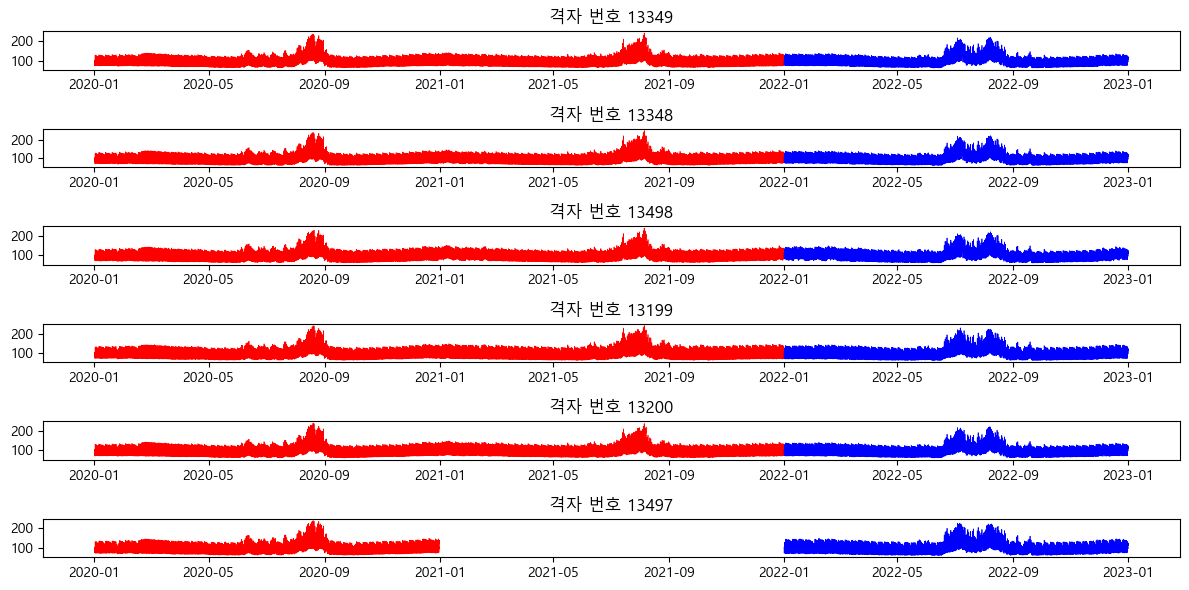

In [96]:
n_nums = len(target_nums)

fig = plt.figure(figsize = (12, 6))
for i, num in enumerate(target_nums):
    plt.subplot(n_nums,1, i+1)
    sns.lineplot(data = train_temp[train_temp['num']==num], x= 'tm', y = 'elec', linewidth = 0.5, color = 'red')
    sns.lineplot(data = val_temp[val_temp['num']==num], x='tm', y='elec', linewidth=0.5, color='blue')
    plt.title(f'격자 번호 {num}')
    plt.subplots_adjust(hspace = 1)
    plt.ylabel('')
    plt.xlabel('')
    
plt.tight_layout()
plt.show()

### X 데이터와 Y 라벨 나누기

In [97]:
target = 'elec'
x_train = train_temp.drop([target, 'tm'], axis=1)
y_train = train_temp[target]

x_val = val_temp.drop([target, 'tm'], axis=1)
y_val = val_temp[target]

In [98]:
x_train.head()

,year,season,month,day,hh24,weekday,week_name,sin_time,cos_time,num,stn,nph_ta,nph_hm,CDH,THI,nph_ws_10m,nph_rn_60m,nph_ta_chi
232,2020,3,1,1,1,2,0,0.258819,0.965926,13349,846,-0.1,28.6,-26.1,21.814004,4.7,0.0,-9.3
245,2020,3,1,1,1,2,0,0.258819,0.965926,13348,846,-0.1,28.6,-26.1,21.814004,4.7,0.0,-9.3
247,2020,3,1,1,1,2,0,0.258819,0.965926,13498,846,-0.1,28.6,-26.1,21.814004,4.7,0.0,-9.3
255,2020,3,1,1,1,2,0,0.258819,0.965926,13199,846,-0.1,28.6,-26.1,21.814004,4.7,0.0,-9.3
258,2020,3,1,1,1,2,0,0.258819,0.965926,13200,846,-0.1,28.6,-26.1,21.814004,4.7,0.0,-9.3


In [100]:
num = target_nums[0]
val_inds = x_val[x_val['num']==num].index
train_inds = x_train[x_train['num']==num].index

train data shape
x:(17544, 18), y:(17544,)


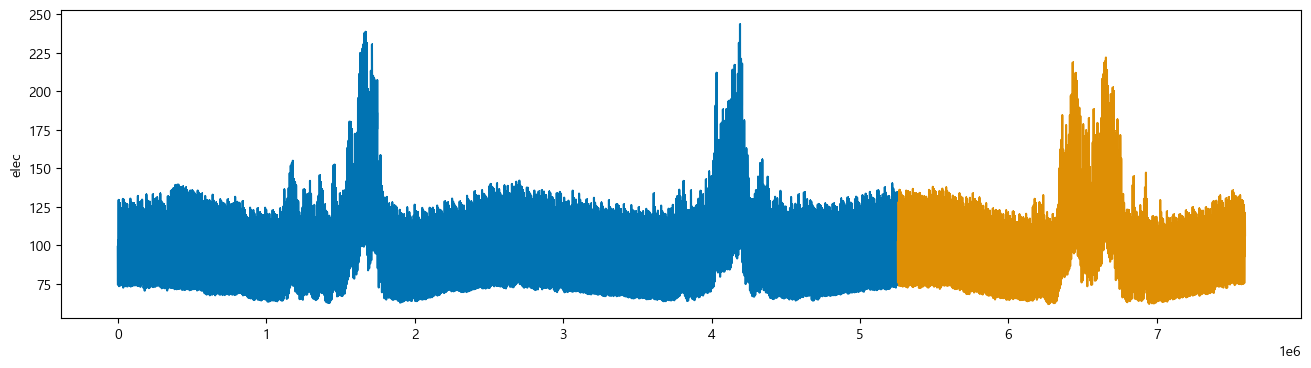

In [101]:
## 7번 건물의 발전량

x_val_num = x_val.loc[val_inds]
x_train_num = x_train.loc[train_inds]
y_val_num = y_val.loc[val_inds]
y_train_num = y_train.loc[train_inds]

print('train data shape\nx:{}, y:{}'.format(x_train_num.shape, y_train_num.shape))

plot_series(y_train_num, y_val_num, markers=[',' , ','])
plt.show()

## ML 모델 : XGBoost

모델은 시계열 데이터에 좋은 성능을 보이는 XGBoost를 선정했습니다.

185개의 AWS 지점당 하나의 모델을 생성하기 위해 185개에 해당하는 파라메타 csv를 생성합니다. 

In [102]:
len(database['stn'].unique())

185

In [103]:
import os 
root = './parameters'
os.makedirs(root, exist_ok=True)

# 데이터프레임 생성
hyper_data = {
    'eta': [0.01] * 185,
    'min_child_weight': [6] * 185,
    'max_depth': [5] * 185,
    'colsample_bytree': [0.8] * 185,
    'subsample': [0.9] * 185
}

hyper_df = pd.DataFrame(hyper_data)

# 데이터프레임을 CSV 파일로 저장
# hyper_df.to_csv('./parameters/hyperparameter_xgb.csv', index=False)
hyper_df.to_csv('./parameters/hyperparameter_xgb.csv')

### 평가지표

In [104]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

평가 Metric인 SMAPE는 실제값보다 작게 추정할 때 더 좋지 않습니다.

이는 전력사용량을 높게 예측하는 것보다 작게 예측할 때 실제로 더 큰 문제가 될 수 있음을 반영한 것으로 보입니다.

In [105]:
print("실제값이 100일 때 50으로 underestimate할 때의 SMAPE : {}".format(SMAPE(100, 50)))
print("실제값이 100일 때 150으로 overestimate할 때의 SMAPE : {}".format(SMAPE(100, 150)))

실제값이 100일 때 50으로 underestimate할 때의 SMAPE : 33.33333333333333
실제값이 100일 때 150으로 overestimate할 때의 SMAPE : 20.0


일반 mse를 objective function으로 훈련할 때 과소추정하는 건물들이 있음을 확인했습니다.

이때문에 SMAPE 점수가 높아진다고 판단, 이를 해결하기 위해 아래와 같이 objective function을 새로 정의했습니다.

새 목적함수는 residual이 0보다 클 때, 즉 실제값보다 낮게 추정할 때 alpha만큼의 가중치를 곱해 반영합니다.

XGBoost는 custom objective function으로 훈련하기 위해선 아래와 같이

gradient(1차 미분함수) / hessian(2차 미분함수)를 정의해 두 값을 return해주어야 합니다.

In [106]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [107]:
from xgboost import XGBRegressor

xgb_params = pd.read_csv('./parameters/hyperparameter_xgb.csv')

xgb_reg = XGBRegressor(n_estimators = 10000, 
                       eta = xgb_params.iloc[47,1], 
                       min_child_weight = xgb_params.iloc[47,2], 
                       max_depth = xgb_params.iloc[47,3], 
                       colsample_bytree = xgb_params.iloc[47,4], 
                       subsample = xgb_params.iloc[47,5], 
                       seed=0)

xgb_reg.fit(
        x_train, y_train, 
        eval_set=[(x_train, y_train), (x_val, y_val)],
        early_stopping_rounds=300,
        verbose=False
        )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)

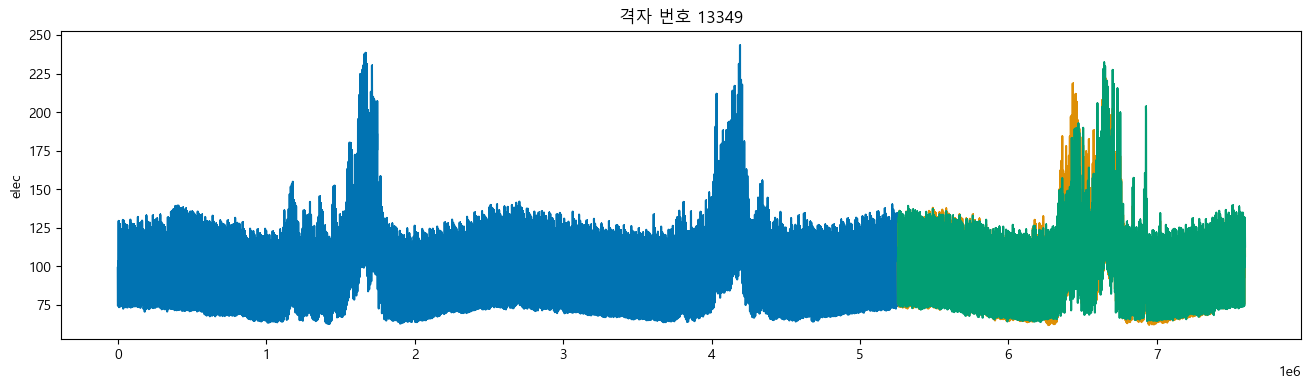

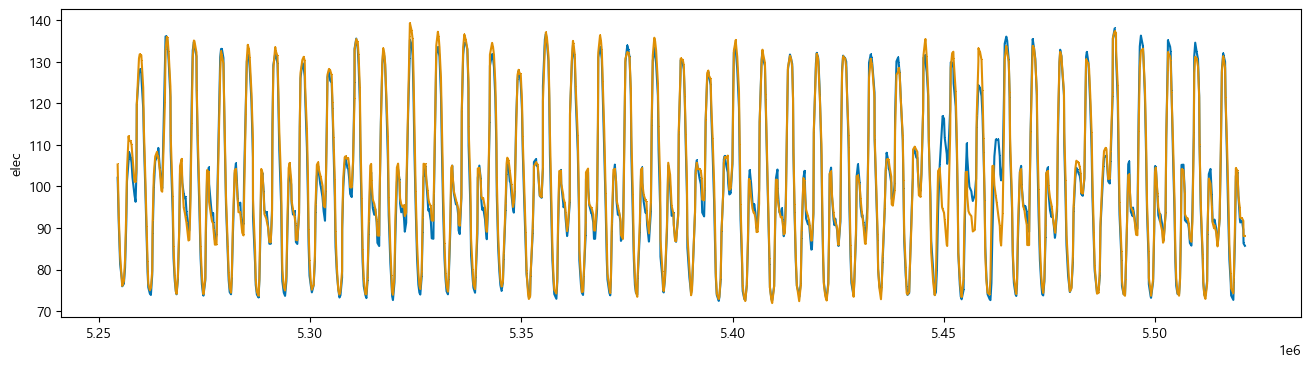

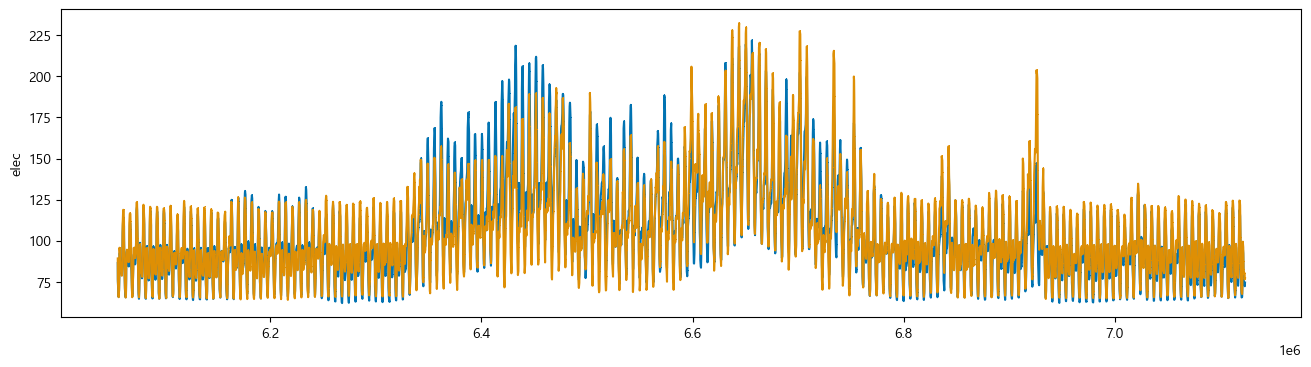

best iterations: 2879
SMAPE : 2.0470887065054764


In [141]:
from sktime.utils.plotting import plot_series

num = target_nums[0]
val_inds = x_val[x_val['num']==num].index
train_inds = x_train[x_train['num']==num].index

x_val_num = x_val.loc[val_inds]
y_val_num = y_val.loc[val_inds]
y_train_num = y_train.loc[train_inds]

## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
pred = xgb_reg.predict(x_val_num)
pred = pd.Series(pred)
pred.index = y_val_num.index      # 범위 맞춰주기 

plot_series(y_train_num, y_val_num, pd.Series(pred), markers=[',' , ',', ','])
plt.title(f'격자 번호 {num}')
plot_series(y_val_num.iloc[:1000], pd.Series(pred).iloc[:1000], markers=[',', ','])
plot_series(y_val_num.iloc[3000:7000], pd.Series(pred).iloc[3000:7000], markers=[',', ','])
plt.show()

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_val_num, pred)))

In [147]:
xgb_reg = XGBRegressor(n_estimators = 10000, 
                       eta = xgb_params.iloc[47,1], 
                       min_child_weight = xgb_params.iloc[47,2], 
                       max_depth = xgb_params.iloc[47,3], 
                       colsample_bytree = xgb_params.iloc[47,4], 
                       subsample = xgb_params.iloc[47,5], 
                       seed=0)

# 커스텀한 목적함수 적용  
xgb_reg.set_params(**{'objective':weighted_mse(150)})

xgb_reg.fit(
        x_train, y_train, 
        eval_set=[(x_train, y_train), (x_val, y_val)],
        early_stopping_rounds=300,
        verbose=False
        )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)

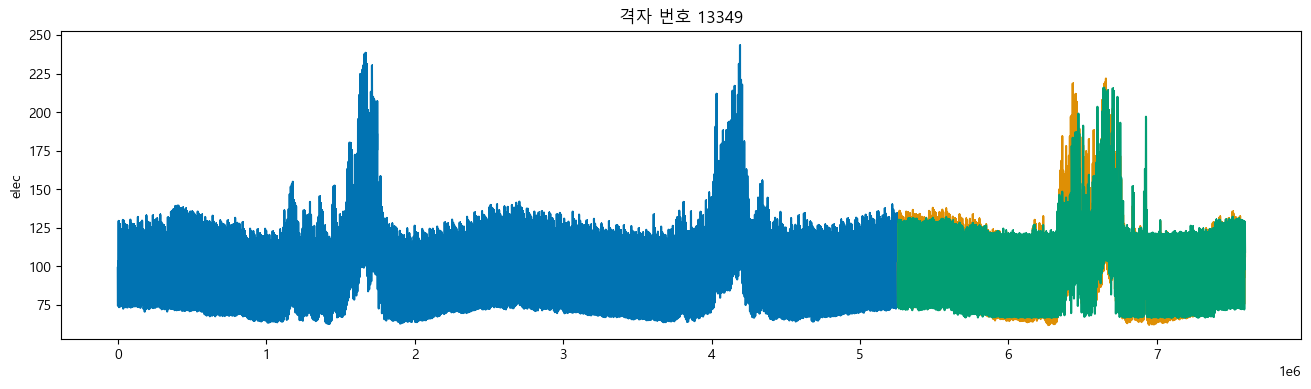

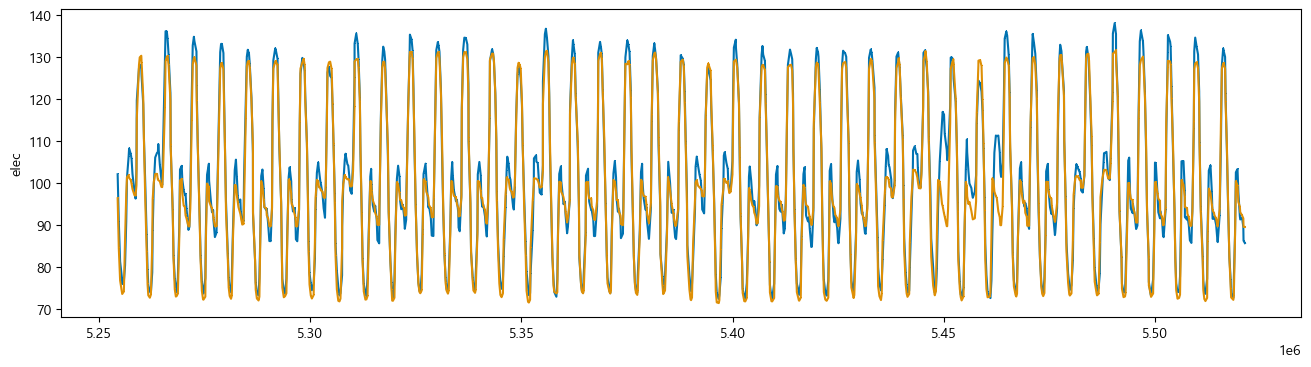

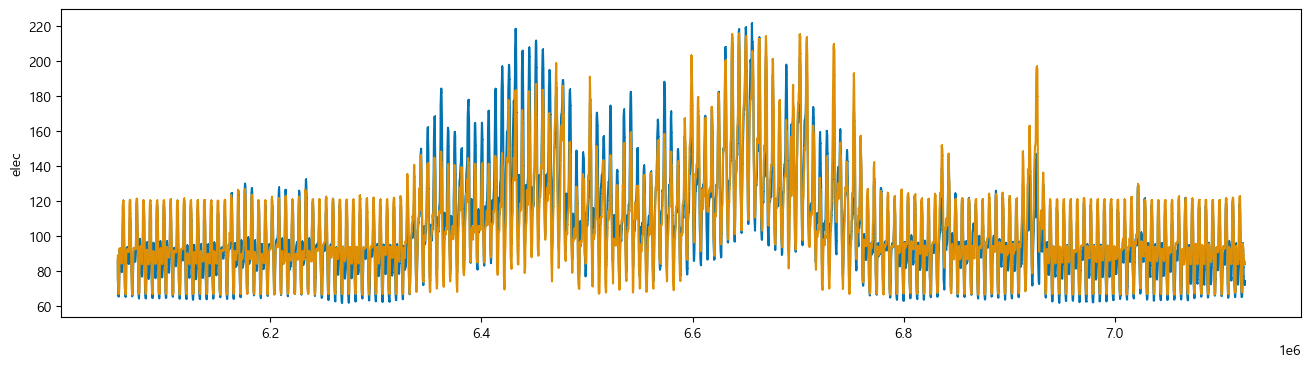

best iterations: 370
SMAPE : 2.500934172542902


In [148]:
from sktime.utils.plotting import plot_series

num = target_nums[0]
val_inds = x_val[x_val['num']==num].index
train_inds = x_train[x_train['num']==num].index

x_val_num = x_val.loc[val_inds]
y_val_num = y_val.loc[val_inds]
y_train_num = y_train.loc[train_inds]

## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
pred = xgb_reg.predict(x_val_num)
pred = pd.Series(pred)
pred.index = y_val_num.index      # 범위 맞춰주기 

plot_series(y_train_num, y_val_num, pd.Series(pred), markers=[',' , ',', ','])
plt.title(f'격자 번호 {num}')
plot_series(y_val_num.iloc[:1000], pd.Series(pred).iloc[:1000], markers=[',', ','])
plot_series(y_val_num.iloc[3000:7000], pd.Series(pred).iloc[3000:7000], markers=[',', ','])
plt.show()

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_val_num, pred)))

결론: 

커스텀 목적함수를 쓰면 오히려 성능이 떨어지네? 

그래도 값을 바꿔보며 확인해야할지도?

In [149]:
from xgboost import XGBRegressor

xgb_params = pd.read_csv('./parameters/hyperparameter_xgb.csv')

xgb_reg = XGBRegressor(n_estimators = 10000, 
                       eta = xgb_params.iloc[47,1], 
                       min_child_weight = xgb_params.iloc[47,2], 
                       max_depth = xgb_params.iloc[47,3], 
                       colsample_bytree = xgb_params.iloc[47,4], 
                       subsample = xgb_params.iloc[47,5], 
                       seed=0)

xgb_reg.fit(
        x_train, y_train, 
        eval_set=[(x_train, y_train), (x_val, y_val)],
        early_stopping_rounds=300,
        verbose=False
        )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)

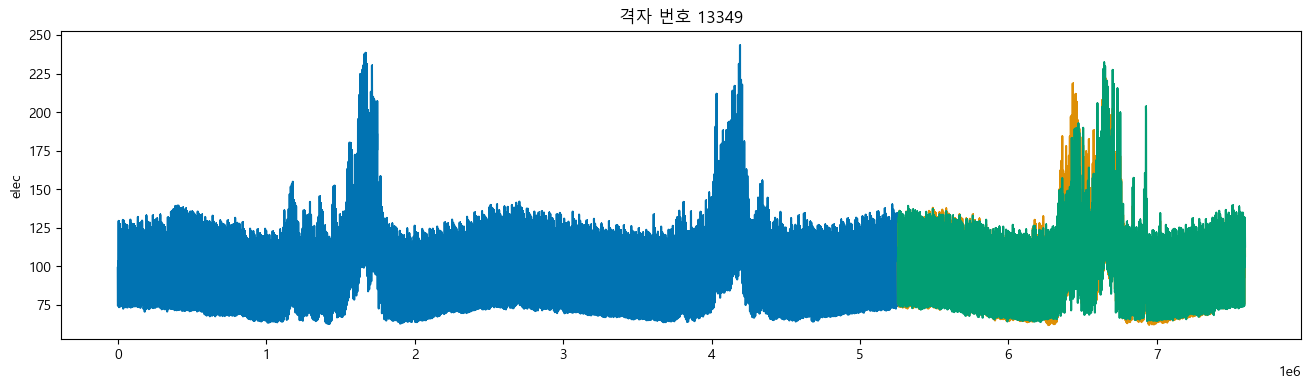

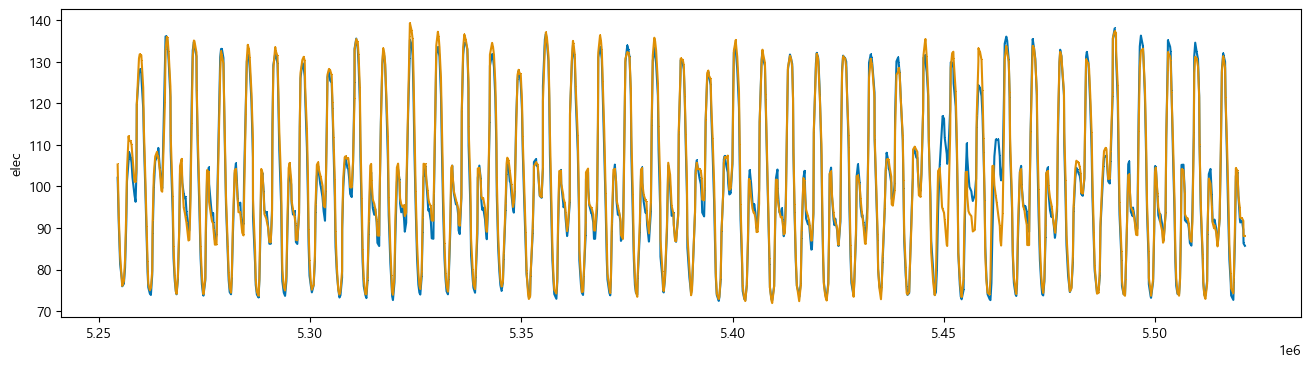

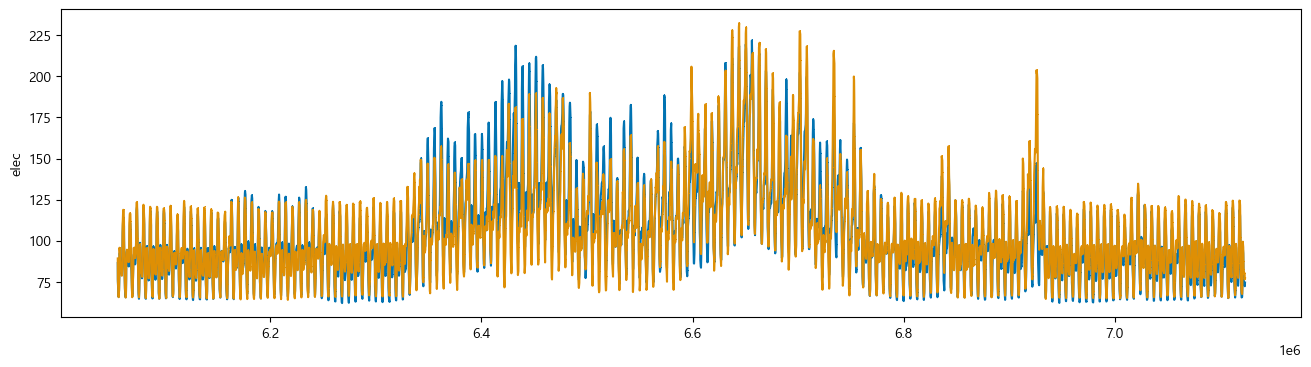

best iterations: 2879
SMAPE : 2.0470887065054764


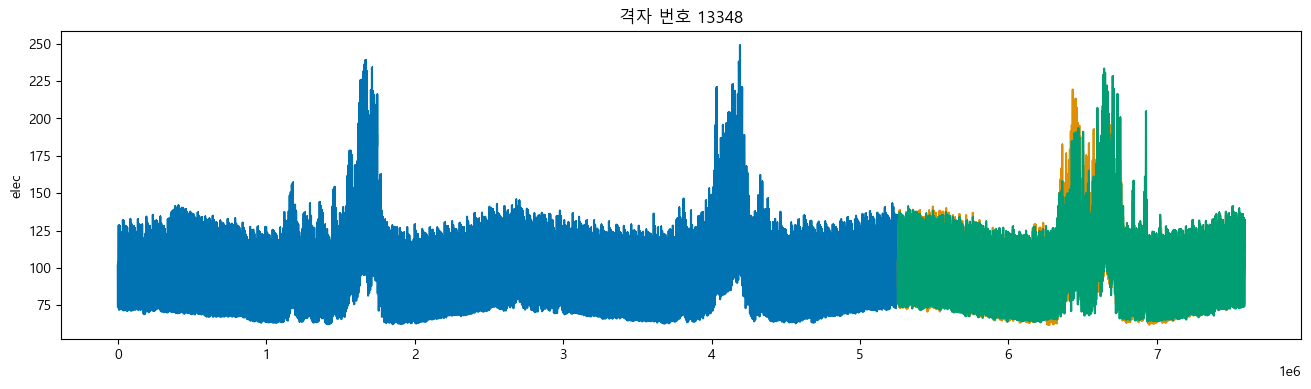

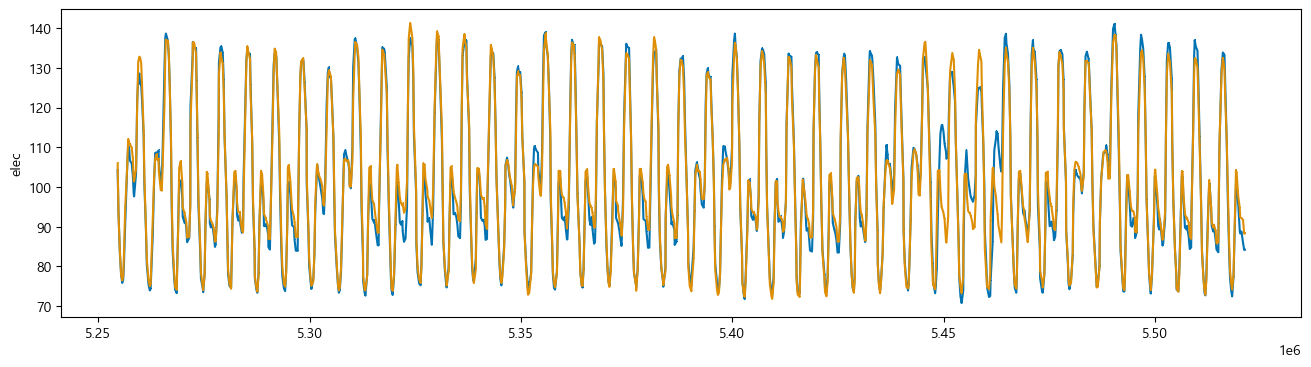

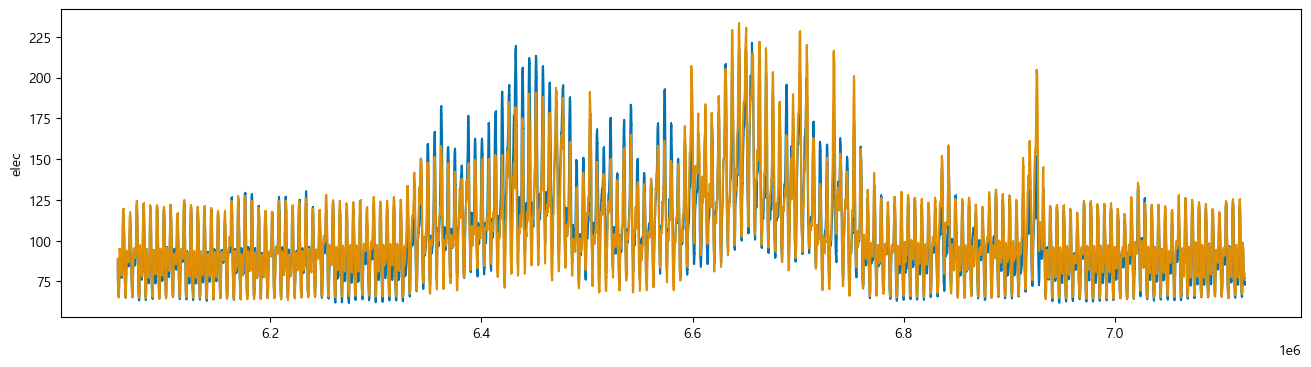

best iterations: 2879
SMAPE : 1.9036843955859608


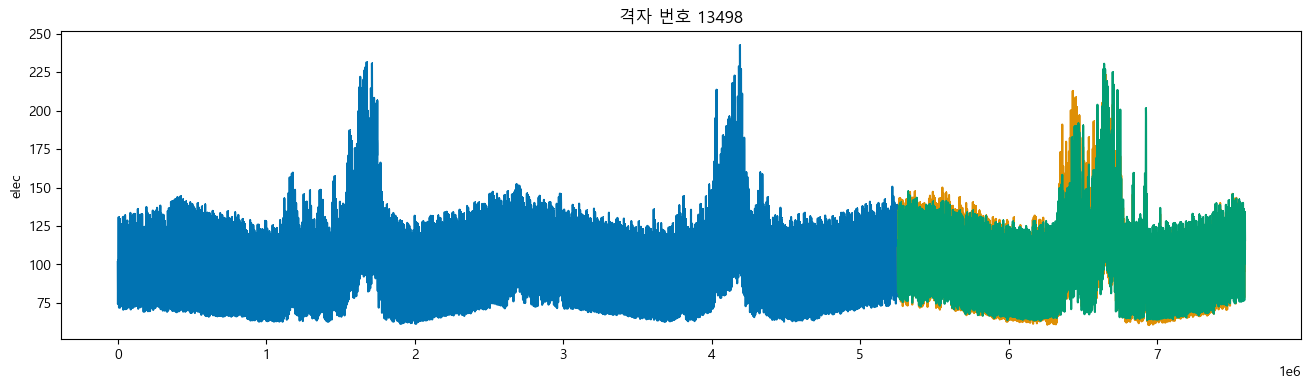

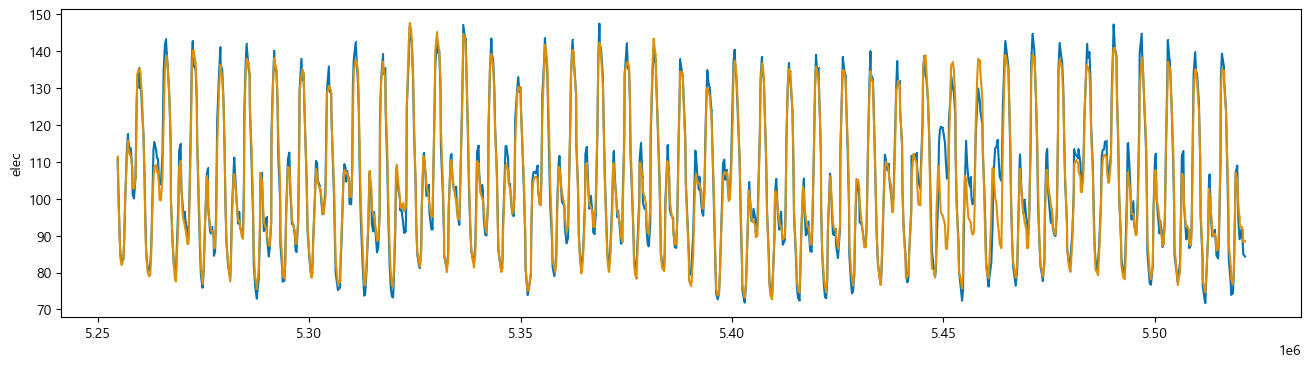

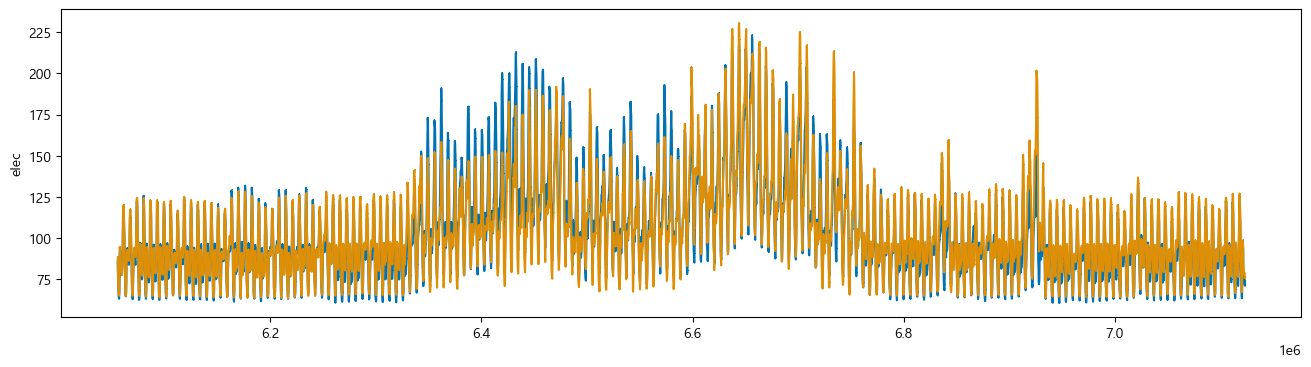

best iterations: 2879
SMAPE : 2.1544187263346464


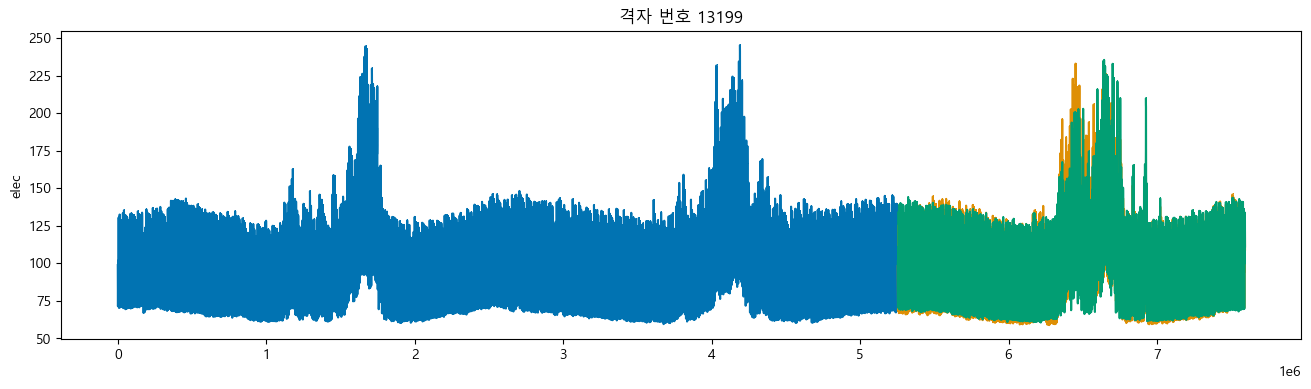

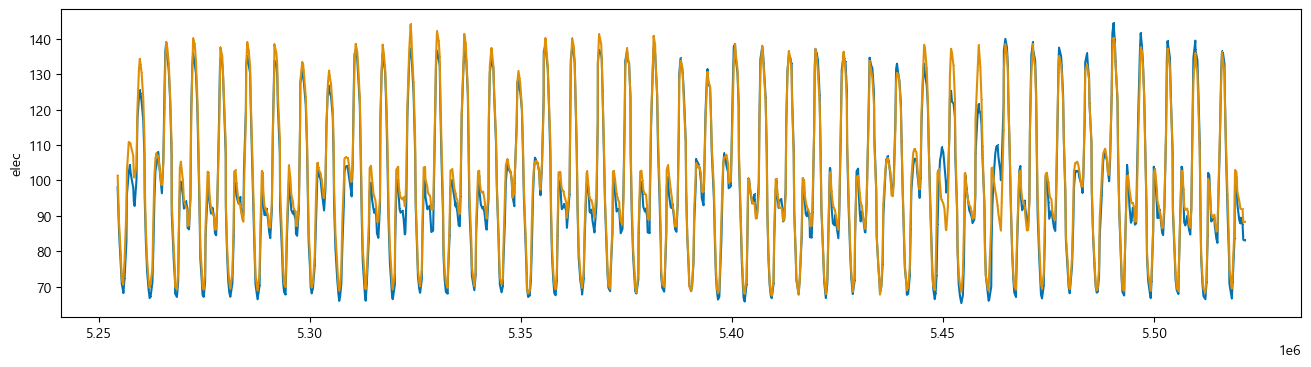

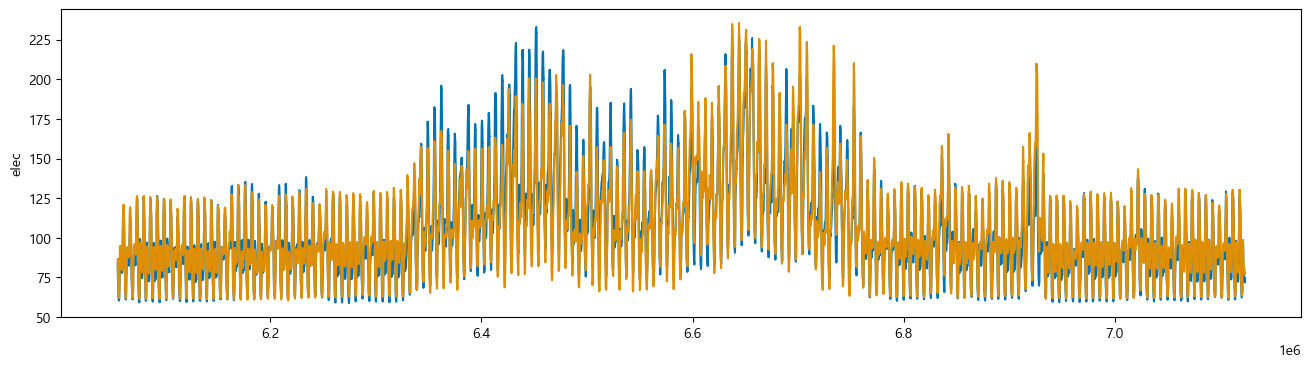

best iterations: 2879
SMAPE : 2.1539794764420486


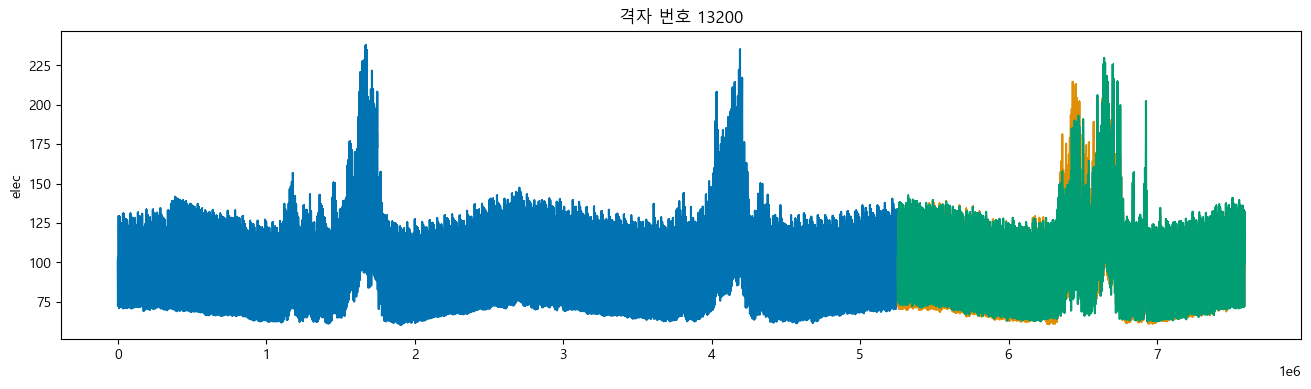

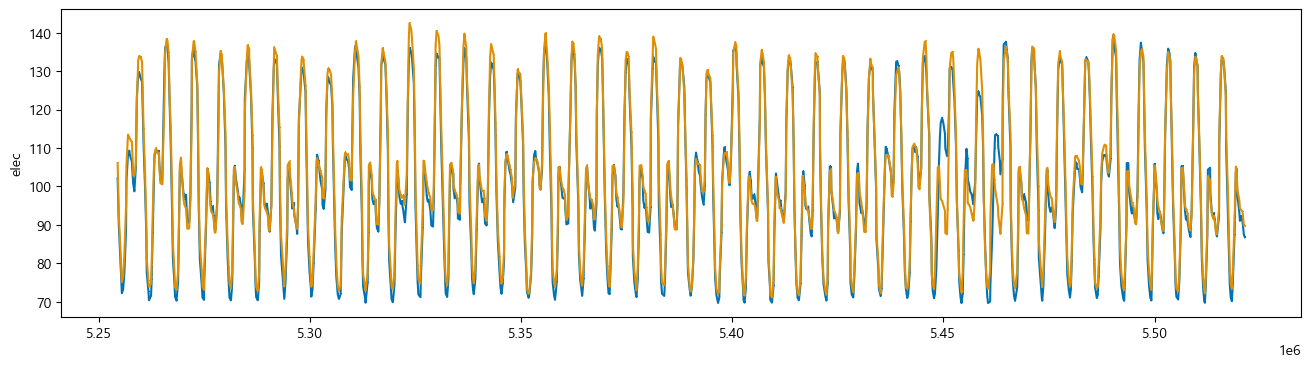

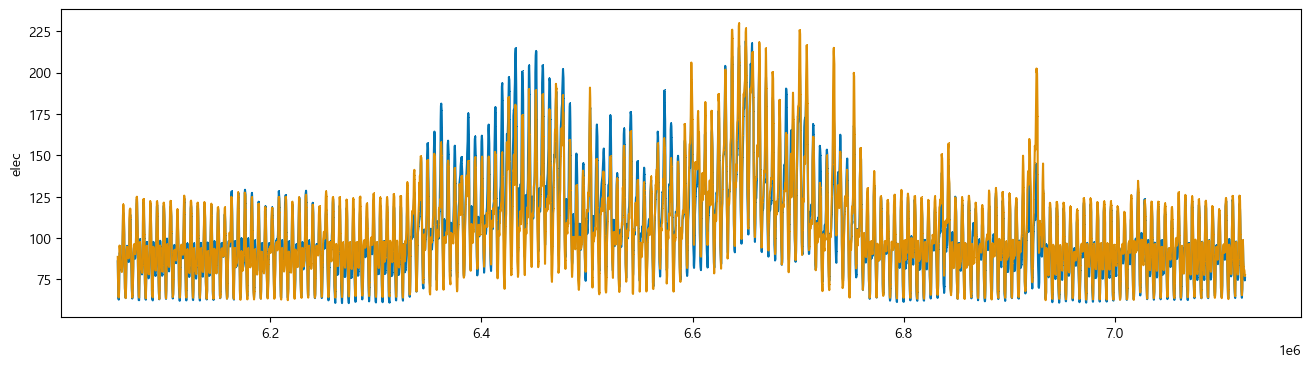

best iterations: 2879
SMAPE : 1.9162480936672912


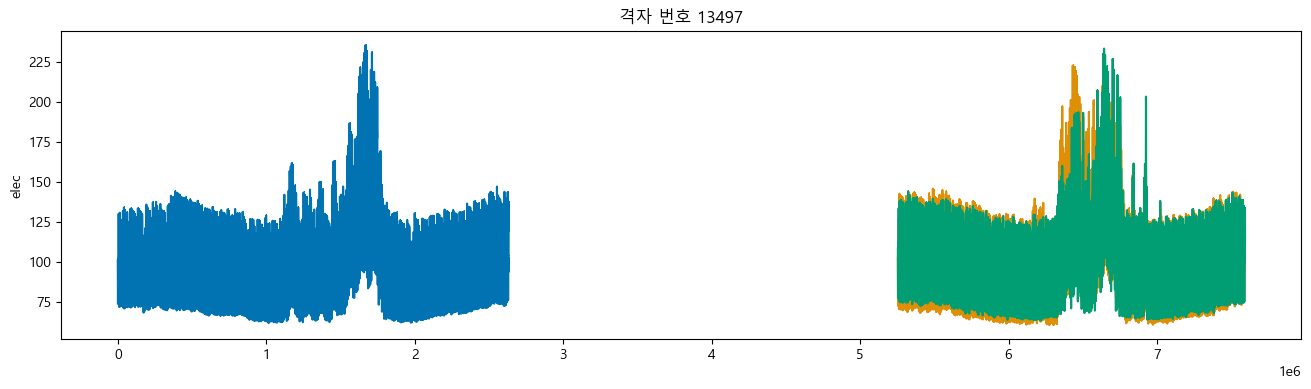

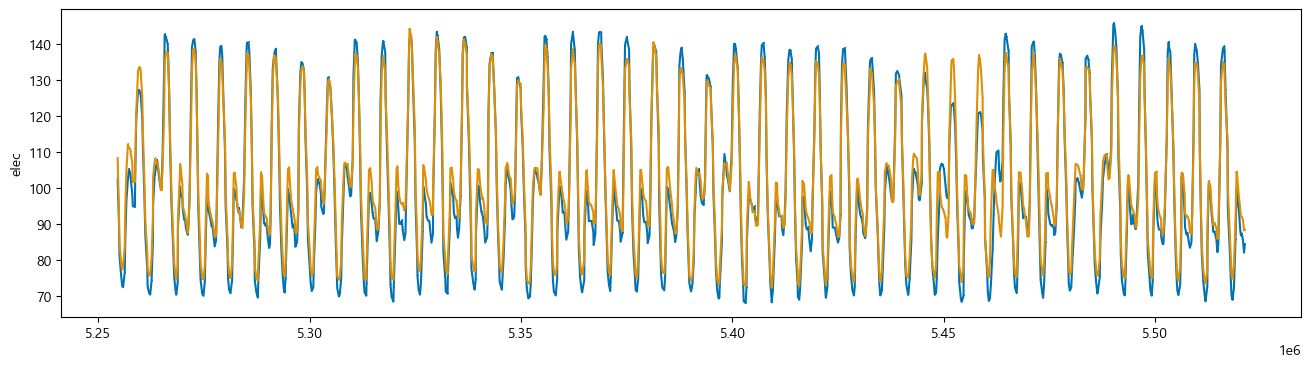

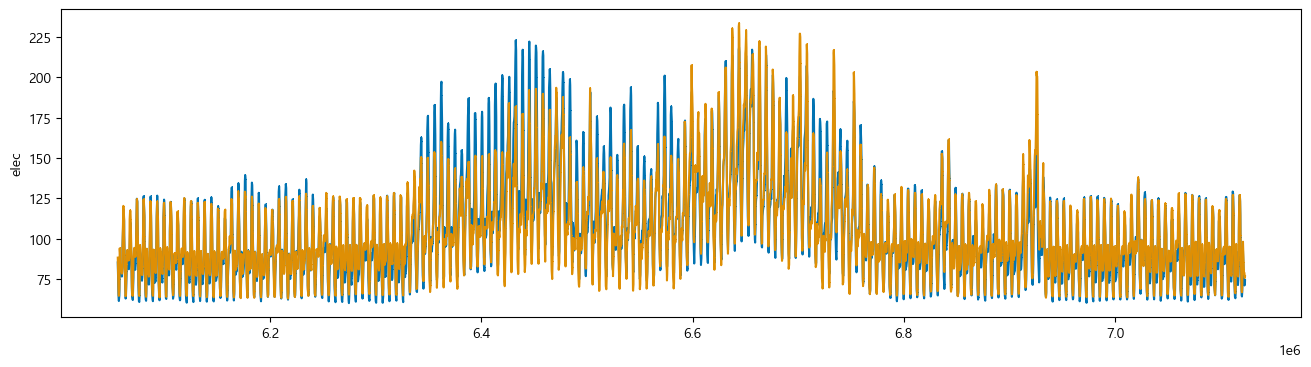

best iterations: 2879
SMAPE : 2.424525505977373


In [150]:
from sktime.utils.plotting import plot_series

for num in target_nums:
    val_inds = x_val[x_val['num']==num].index
    train_inds = x_train[x_train['num']==num].index

    x_val_num = x_val.loc[val_inds]
    y_val_num = y_val.loc[val_inds]
    y_train_num = y_train.loc[train_inds]

    ## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
    pred = xgb_reg.predict(x_val_num)
    pred = pd.Series(pred)
    pred.index = y_val_num.index      # 범위 맞춰주기 

    plot_series(y_train_num, y_val_num, pd.Series(pred), markers=[',' , ',', ','])
    plt.title(f'격자 번호 {num}')
    plot_series(y_val_num.iloc[:1000], pd.Series(pred).iloc[:1000], markers=[',', ','])
    plot_series(y_val_num.iloc[3000:7000], pd.Series(pred).iloc[3000:7000], markers=[',', ','])
    plt.show()

    print('best iterations: {}'.format(xgb_reg.best_iteration))
    print('SMAPE : {}'.format(SMAPE(y_val_num, pred)))